In [ ]:
import warnings

import df_utils as utils
from df_model import (
    CLF_DECISION_TREE,
    CLF_LOGISTIC_REGRESSION,
    CLF_SUPPORT_VECTOR,
    PIPE_CLASSIFIER,
    PIPE_ENCODER,
    PIPE_IMPUTER,
    PIPE_SCALER,
    PIPE_SELECTOR,
    PIPE_TRANSFORMER,
    DataModel,
)
# from sklearnex import patch_sklearn # pip install scikit-learn-intelex

In [ ]:
############ PRODUCTION SETTINGS ############

# optimize scikit runtime for intel processor
# patch_sklearn() # uncomment if installed

# ignore unproblematic parameter warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
%%capture
# run preprocessing notebook
%run df3_loan_prep.ipynb 

In [4]:
############ CONFIGURATION ############

# list desired settings
data_config = {
    "dataset": "loan",
    "index": "ID",
    "target": "grade",
    "has_imbalance": True,
    "has_test": True,
    "use_raw": False,
    "n_folds": 2,
    "scoring": "f1_weighted",
    "cv_random": True,
    "cv_iter": 6,
}

# choose desired final classifiers and pipeline modelling steps
final_models = {
    CLF_LOGISTIC_REGRESSION: [PIPE_ENCODER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR],
    CLF_SUPPORT_VECTOR: [PIPE_ENCODER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR],
    CLF_DECISION_TREE: [PIPE_ENCODER, PIPE_IMPUTER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR, PIPE_CLASSIFIER],
}

# pipeline steps: encoders, imputers, transformers, scalers, feature selectors, classifiers
[PIPE_ENCODER, PIPE_IMPUTER, PIPE_TRANSFORMER, PIPE_SCALER, PIPE_SELECTOR, PIPE_CLASSIFIER]

['enc', 'imp', 'trf', 'scl', 'fsl', 'clf']

In [5]:
# NOTE: configuration has been chosen such that all three classifiers need a reasonable runtime and not the optimal results
# during testing and the kaggle competition, each classifier was isolated and provided with different ...
# parameter settings ("file df_model.py")
# performance measures (var "scoring")
# pipeline steps (var "final_models")
# cross-validation folds (var "n_folds")
# hypertuning iterations (var "cv_iter")

In [6]:
# import data set
(data, data_test) = utils.import_data(data_config["dataset"], data_config["has_test"], data_config["use_raw"])

importing from: data/data_clean/loan.csv


In [7]:
# set data index
data = utils.set_data_index(data, data_config["index"])
if data_config["has_test"]:
    data_test = utils.set_data_index(data_test, data_config["index"])

In [8]:
############ MODELLING ############

# create data set model
data_model = DataModel(data, data_config["target"], data_test, data_config["has_imbalance"], data_config["n_folds"])

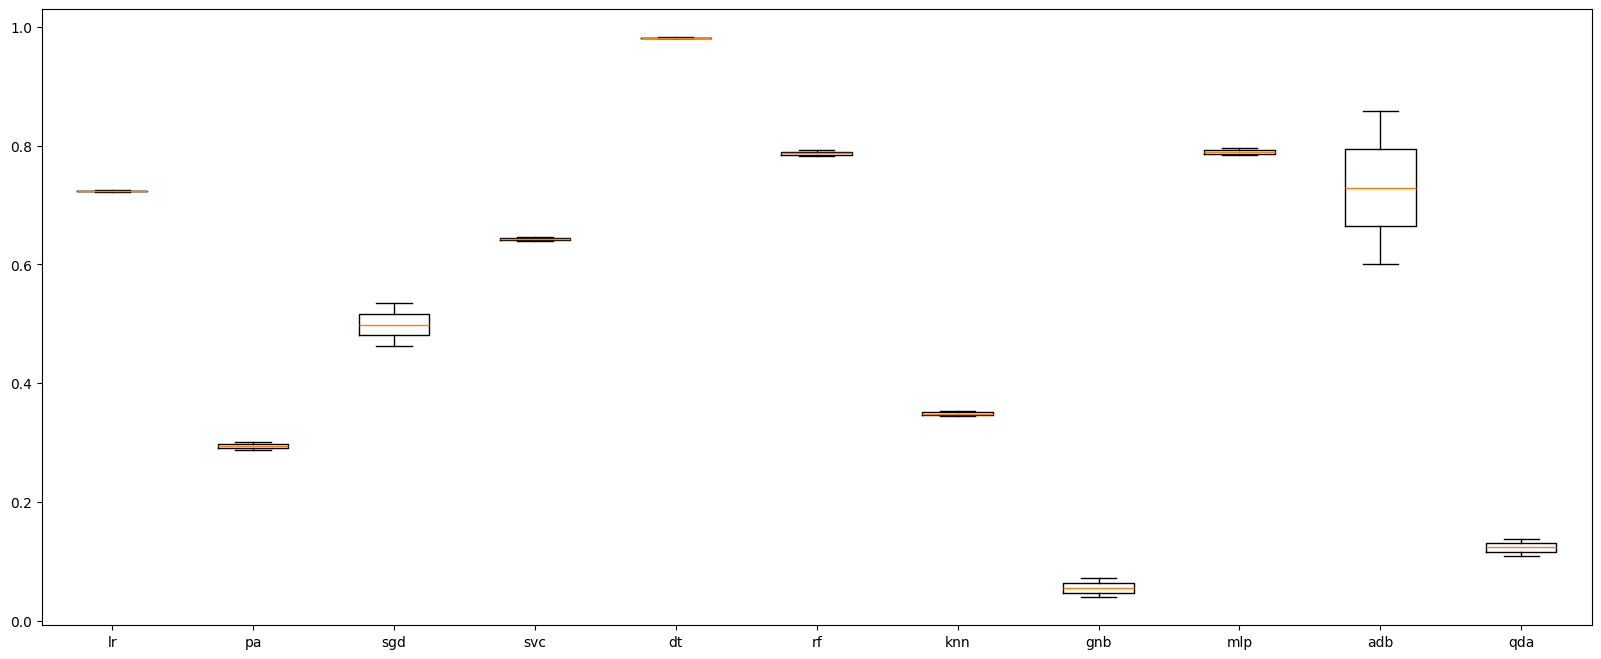

In [9]:
############ CLASSIFIER SELECTION ############

# plot classifier performance on training data out of the box
data_model.plot_models_train_performance(scale=True, encode=True)

In [10]:
# print classifier performance on test data out of the box
data_model.print_models_test_performance(scale=True, encode=True)

lr - accuracy: 0.796 / f1: 0.7862429586072265
pa - accuracy: 0.575 / f1: 0.5269144044946256
sgd - accuracy: 0.555 / f1: 0.5408461658939634
svc - accuracy: 0.776 / f1: 0.7639500032829196
dt - accuracy: 0.987 / f1: 0.9870273641292122
rf - accuracy: 0.809 / f1: 0.7873371903781011
knn - accuracy: 0.373 / f1: 0.35277680409131573
gnb - accuracy: 0.024 / f1: 0.02617081720316796
mlp - accuracy: 0.844 / f1: 0.8440936210487132
adb - accuracy: 0.837 / f1: 0.8295332374230622
qda - accuracy: 0.183 / f1: 0.13573004871894545


In [11]:
############ HYPERPARAMETER TUNING ############

# tune the parameters of the chosen final classifiers and pipeline steps
optimal_models = {}
for classifier_name, model_steps in final_models.items():
    print(f"---------current model: {classifier_name}---------")
    optimal_models[classifier_name] = data_model.train_model_classifier(classifier_name, model_steps, random=data_config["cv_random"], n_iter=data_config["cv_iter"], performance=data_config["scoring"])

---------current model: lr---------
tuned enc score: 0.3427708459276132
tuned trf score: 0.3427708459276132
tuned scl score: 0.78602804807482
tuned fsl score: 0.8567996357145757
---------current model: svc---------
tuned enc score: 0.2828913066511512
tuned trf score: 0.3133629735772139
tuned scl score: 0.31493181139969817
tuned fsl score: 0.32603165850879523
---------current model: dt---------
tuned enc score: 0.9819296004295334
tuned imp score: 0.9819296004295334
tuned trf score: 0.9819296004295334
tuned scl score: 0.9819296004295334
tuned fsl score: 0.9703692742073682
tuned clf score: 0.9610067407555454


In [12]:
############ MODEL EVALUATION ############

# display the produced model pipelines
for model in optimal_models.values():
    display(model)

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['term', 'emp_length', 'home_ownership', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')),
                                                 ('num...
       'issue_d_month', 'issue_d_year', 'earliest_cr_line_month',
       'earliest_cr_line_year', 'last_pymnt_d_month', 'last_pymnt_d_year',
       'last_credit_pull_d_month', 'last_credit_pull_d_year'],
      dtype='object'))])),
                ('imp', 'passthrough'), ('trf', None),
                ('scl', StandardScaler()), ('fsl', SelectKBest(k=43)),
                ('clf',
                 LogisticRegression(max_iter=500, random_state=42,
                                    solver='saga'))])

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['term', 'emp_length', 'home_ownership', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')),
                                                 ('num...
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])),
                                                 ('negative', 'passthrough',
                                                  array([], dtype=int64))])),
                ('scl', RobustScaler()),
                ('fsl', PCA(n_components=13, random_state=42)),
                ('clf', SVC(random_state=42))])

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['term', 'emp_length', 'home_ownership', 'verification_status',
       'loan_status', 'pymnt_plan', 'purpose', 'addr_state',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')),
                                                 ('num...
       'issue_d_month', 'issue_d_year', 'earliest_cr_line_month',
       'earliest_cr_line_year', 'last_pymnt_d_month', 'last_pymnt_d_year',
       'last_credit_pull_d_month', 'last_credit_pull_d_year'],
      dtype='object'))])),
                ('imp', SimpleImputer()), ('trf', None), ('scl', None),
                ('fsl', SelectKBest(k=43)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=77,
                                        random_state=42))])

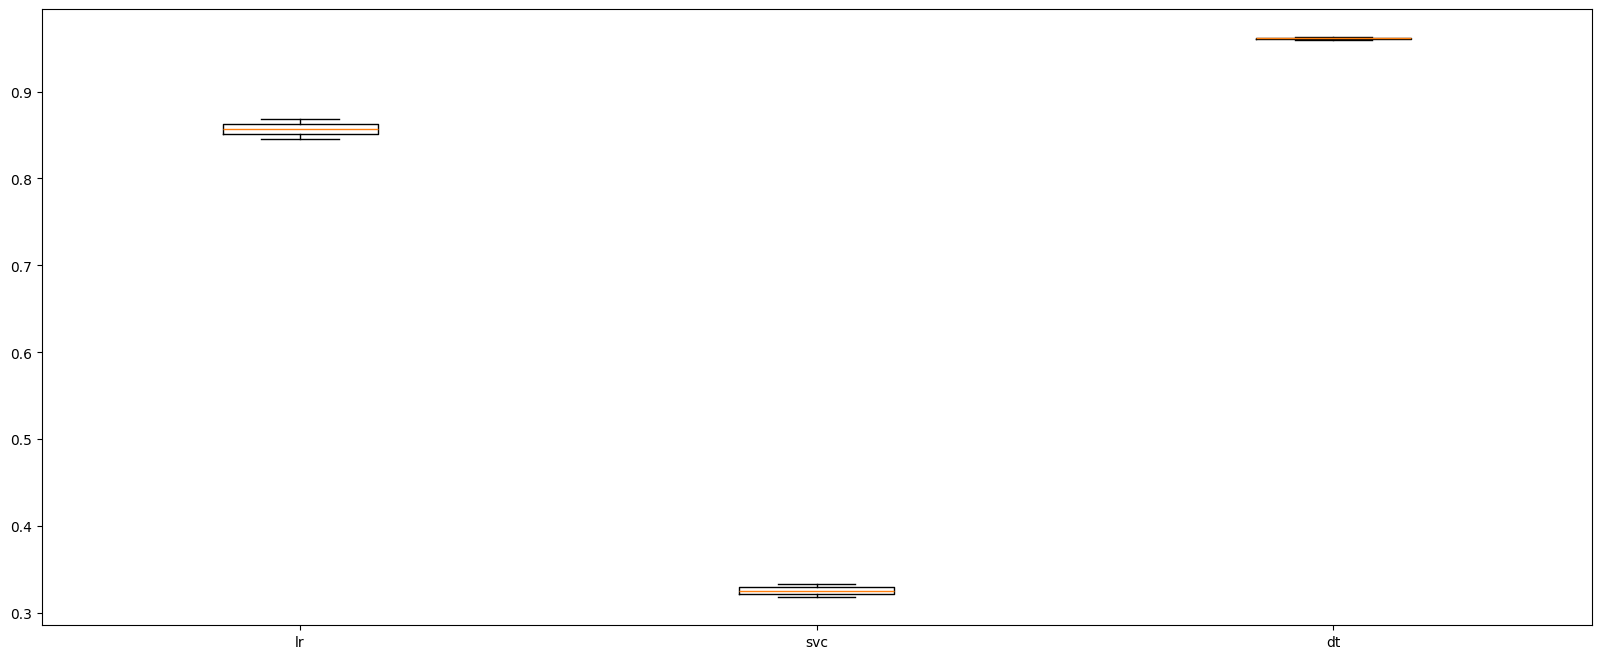

In [13]:
# check for train classifier performance with optimized settings
data_model.plot_models_train_performance(optimal_models)

In [14]:
# check for test classifier performance with optimized settings
data_model.print_models_test_performance(optimal_models)

lr - accuracy: 0.873 / f1: 0.8683291098469245
svc - accuracy: 0.37 / f1: 0.33031770672425537
dt - accuracy: 0.969 / f1: 0.9689555284790538


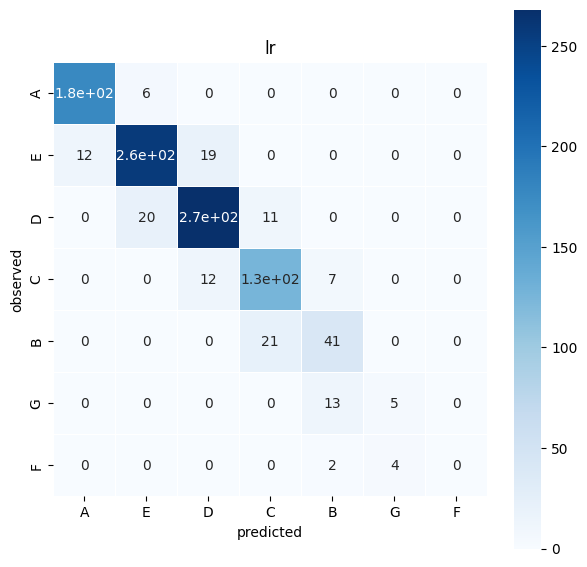

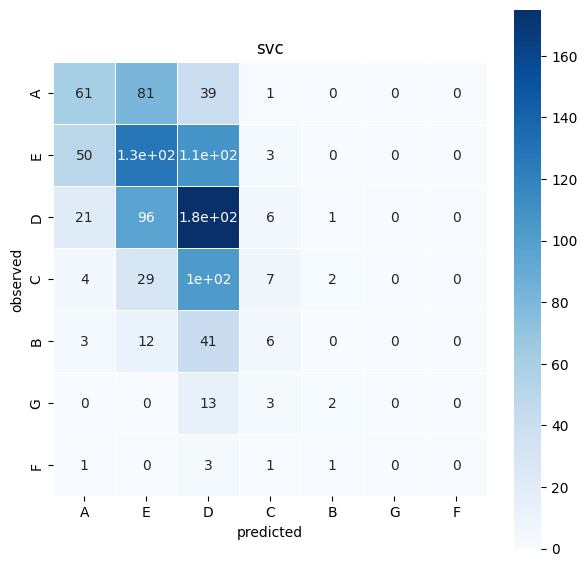

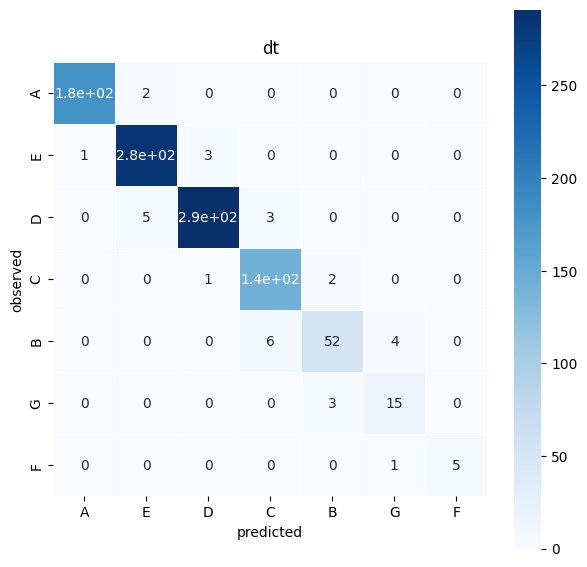

In [15]:
# visualize confusion matrix of models on test data
data_model.plot_models_test_cmatrix(optimal_models)

In [16]:
############ KAGGLE HAND-IN ############

# prepare final prediction on new test data
if data_config["has_test"]:
    for model_name, model in optimal_models.items():
        data_test_fin = data_model.fit_model_newdata(model)
        utils.export_data(data_test_fin, data_config["dataset"] + "_" + model_name, predict=True)

        display(data_test_fin)

,grade
ID,
3582,B
60498,C
53227,B
21333,C
3885,F
...,...
89555,C
88135,B
51888,C


,grade
ID,
3582,A
60498,C
53227,C
21333,B
3885,C
...,...
89555,C
88135,A
51888,B


,grade
ID,
3582,B
60498,C
53227,B
21333,C
3885,F
...,...
89555,C
88135,B
51888,C
